# Part 2

Basic Analytics and Visualizations: Using Apache Spark, perform comprehensive data analysis on the encounter data and create visualizations that reveal meaningful patterns. 

Your analysis must include:

Evan: COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])

Evan: Cumulative case count of Covid between the earliest case observed in the dataset and last case observed

Evan: Symptoms for all COVID-19 patients versus patients that admitted into the intensive care unit due to COVID.

Syd: Rank medications by frequency of prescription. 

Syd: Analyze medication patterns across different demographic groups (e.g., top 3 per age group)

Kayla: Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset.
  ? market basket analysis 
  3 visuals 

One each: Evan, Kayla, and Syd::: 
An independent group analysis: You need to develop and execute THREE original analyses that provide meaningful insights about COVID-19 patterns in this dataset. 
      For each analysis:
      Clearly state your analytical question/hypothesis
      Justify why this analysis is valuable
      Show your Spark code and methodology
      Present results with appropriate visualizations


df.filter(col("demographics.address.state")=="massachutses".collect())

dbfs:/FileStore/shared_uploads/ktorres2@hawaii.edu/medical_records.parquet
dbfs:/FileStore/shared_uploads/ktorres2@hawaii.edu/parsed_notes.jsonl

In [0]:
## Add all imports here
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.functions import lower, col, desc, rank, date_trunc, trim, length, split, size, mean, stddev, min, max, countDistinct, datediff, log, month, year, concat_ws, col, explode, array, count, when, lit, collect_list, posexplode, expr
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col, explode, array_contains, count, when, collect_list, size
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb, to_hex
import matplotlib.colors as mc
import colorsys
import gzip
import seaborn as sns

In [0]:
spark = SparkSession.builder \
    .appName("Co-Morbidity Analysis") \
    .getOrCreate()

medical_records_df = spark.read.parquet("dbfs:/FileStore/shared_uploads/kimsyd@hawaii.edu/medical_records.parquet")

parsed_notes_df = spark.read.json("dbfs:/FileStore/shared_uploads/kimsyd@hawaii.edu/parsed_notes_jsonl-1.gz")

## COVID demographics breakdown

"COVID-19 Case Demographics: Case breakdown by age ranges ([0-5], [6-10], [11-17], [18-30], [31-50], [51-70], [71+])"

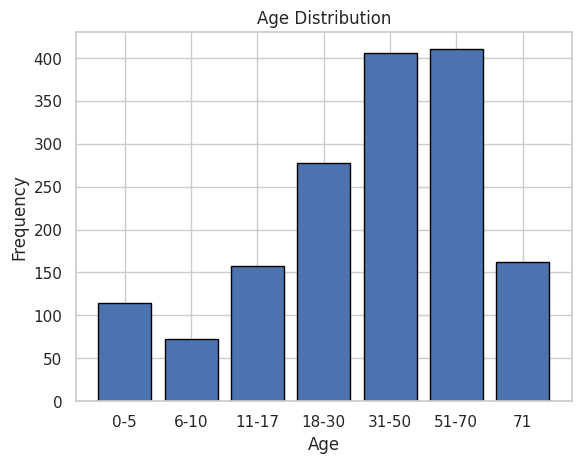

In [0]:

#File saved
df = spark.read.json("dbfs:/FileStore/shared_uploads/kimsyd@hawaii.edu/parsed_notes_jsonl-1.gz")

#Locates specific parts
date_of_birth = df.select('demographics.date_of_birth')
encounter = df.select('encounter.date')

#Appends it to existing dataframe (would make a new one but I've forgotten how to connect everything)
df = df.withColumn("birthdate",F.to_date(F.col("demographics.date_of_birth"), "yyyy-MM-dd"))
df = df.withColumn("encounter_date",F.to_date(F.col("encounter.date"), "yyyy-MM-dd"))

#Age is calculated throuhg operations
df = df.withColumn("age", F.floor(F.datediff(F.col("encounter_date"),F.col("birthdate")) / 365.25))

ages = []
ranges = ['0-5', '6-10', '11-17', '18-30', '31-50', '51-70', '71']

age = (df.select('age').filter((df['age'] >= 0) & (df['age'] <= 5)))
ages.append(len(age.toPandas()))

age = (df.select('age').filter((df['age'] >= 6) & (df['age'] <= 10)))
ages.append(len(age.toPandas()))

age = (df.select('age').filter((df['age'] >= 11) & (df['age'] <= 17)))
ages.append(len(age.toPandas()))

age = (df.select('age').filter((df['age'] >= 18) & (df['age'] <= 30)))
ages.append(len(age.toPandas()))

age = (df.select('age').filter((df['age'] >= 31) & (df['age'] <= 50)))
ages.append(len(age.toPandas()))

age = (df.select('age').filter((df['age'] >= 51) & (df['age'] <= 70)))
ages.append(len(age.toPandas()))

age = (df.select('age').filter((df['age'] >= 71)))
ages.append(len(age.toPandas()))

plt.bar(ranges, ages, edgecolor='black')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

plt.show()

"Cumulative case count of Covid between the earliest case observed in the dataset and last case observed"

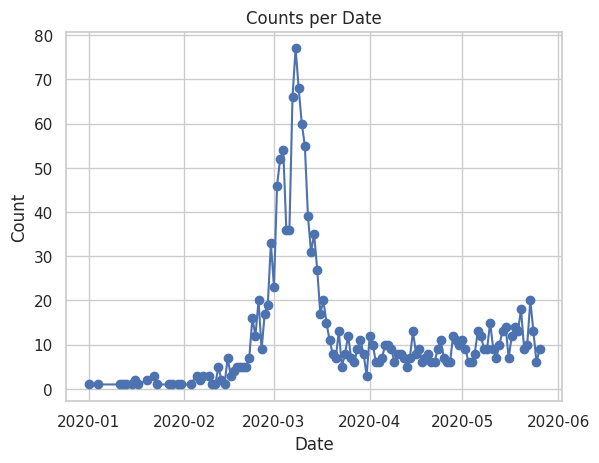

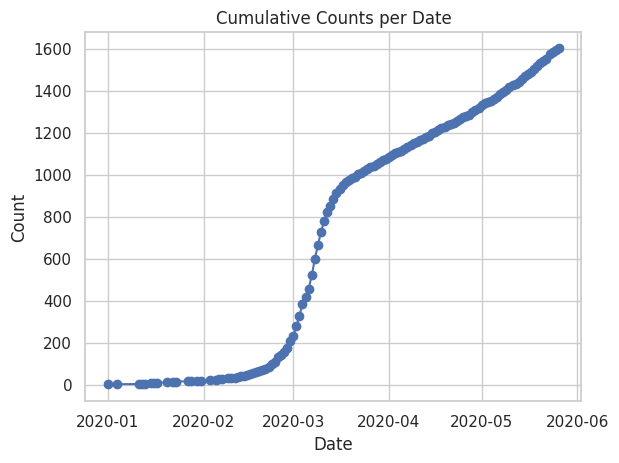

In [0]:
df_date = df.groupBy('encounter_date').agg(F.count('*').alias('count'))
df_date_ordered = df_date.orderBy(df_date.encounter_date).dropna()

graph = df_date_ordered.toPandas()
graph['encounter_date'] = pd.to_datetime(graph['encounter_date'])
graph['cum_count'] = graph['count'].cumsum()


plt.plot(graph['encounter_date'], graph['count'], marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Counts per Date')

plt.show()

plt.plot(graph['encounter_date'], graph['cum_count'], marker='o', linestyle='-', color='b')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Cumulative Counts per Date')

plt.show()

## Original Analysis #1

### Symptoms vs Age Interaction:
**Determine the ages in which symptoms are the most prevalent.**
- Question: Are certain ages more prone to a higher number of symptoms?
- Hypothesis: Older ages should have more symptoms prevalent due to their immune systems declining with age.
- Knowing what age you're most suceptible to symptoms and problems is very important to making a proper plan to when you reach that age.

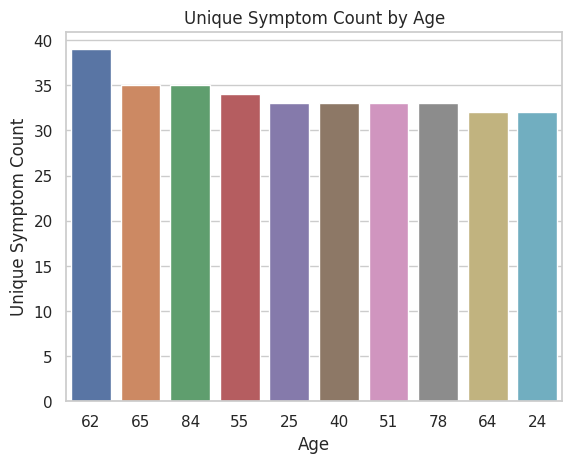

In [0]:
symptom_count = []
age_count = []

file_path = "dbfs:/FileStore/shared_uploads/kimsyd@hawaii.edu/parsed_notes_jsonl-1.gz"

dbutils.fs.cp(file_path, file_path.replace("dbfs:/FileStore/shared_uploads/", "file:/tmp/"))
file_location = file_path.replace("dbfs:/FileStore/shared_uploads/", "/tmp/")

json_obj = []

with gzip.open(file_location, "rt") as file: #Loads jsonl file
  for line in file:
    json_obj.append(json.loads(line))

for i in json_obj:
  try:
    for j in range(len(i['conditions'])):
      symptom_count.append(i['conditions'][j]['description'])
      age_count.append(i['demographics']['age'])
  except IndexError:
    pass

symptom_df = spark.createDataFrame([(x,) for x in symptom_count], ['SYMPTOM'])
age_df = spark.createDataFrame([(x,) for x in age_count], ['AGE'])

symptom_df = symptom_df.withColumn("id1",F.monotonically_increasing_id())
age_df = age_df.withColumn("id2",F.monotonically_increasing_id())

joined = symptom_df.join(age_df,F.col("id1")==F.col("id2"),"inner").drop("id1","id2")

df_details = joined.groupBy("AGE").agg(F.count("SYMPTOM").alias("symptom_count"),
                                            F.collect_list("SYMPTOM").alias("symptoms"))

df_details_cleaned = df_details.withColumn("unique_symptoms", F.array_distinct("symptoms")) \
                               .withColumn("unique_symptom_count", F.size("unique_symptoms"))

df_details_cleaned = df_details_cleaned.drop("symptoms", "symptom_count") 
                        
df_details_sorted = df_details_cleaned.orderBy(F.desc("unique_symptom_count"))

df_details_sorted_pd = df_details_sorted.limit(10).toPandas()
df_details_sorted_pd_order = df_details_sorted_pd.sort_values('unique_symptom_count', ascending=False)

sns.barplot(data=df_details_sorted_pd_order, x='AGE',y='unique_symptom_count', order=df_details_sorted_pd_order['AGE'])
plt.title('Unique Symptom Count by Age')
plt.xlabel('Age')
plt.ylabel('Unique Symptom Count')
plt.show()

#for i in df_details_sorted.select("unique_symptoms").head(1)[0][0]: #Uncomment to show all symptoms of the number 1 age
#  print(i)


## Co-Morbidity and Disease Severity Analysis
*Co-morbidities refer to the presence of one or more additional medical conditions or diseases in a person who is already infected with COVID-19. These existing health issues can worsen the severity of COVID-19 and increase the risk of complications, hospitalization, or death.*

"Identify and plot co-morbidity information from the patient records (e.g., hypertension, obesity, prediabetes, etc.) provided in the dataset."

In [0]:
print("medical records schema:")
medical_records_df.printSchema()

print("parsed notes schema:")
parsed_notes_df.printSchema()


medical records schema:
root
 |-- demographics: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- state: string (nullable = true)
 |    |-- age: long (nullable = true)
 |    |-- date_of_birth: string (nullable = true)
 |    |-- gender: string (nullable = true)
 |    |-- insurance: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- encounter: struct (nullable = true)
 |    |-- date: string (nullable = true)
 |    |-- facility_id: string (nullable = true)
 |    |-- provider_id: string (nullable = true)
 |    |-- time: string (nullable = true)
 |-- conditions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- code: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |-- medications: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- code: string (nullable = true)
 |    |    |-- description: s

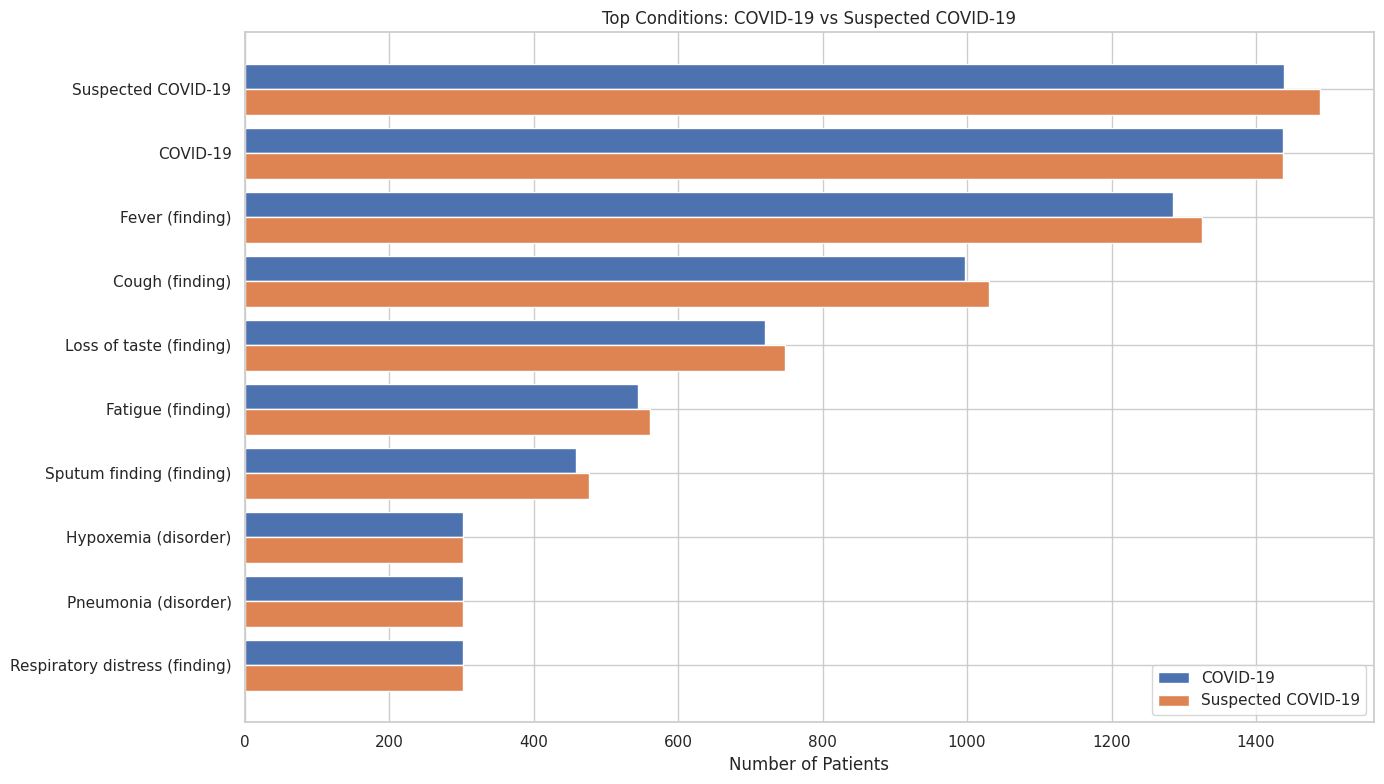

In [0]:
# get conditions and demographic
conditions_df = medical_records_df \
    .select(col("demographics.name"), explode(col("conditions")).alias("condition")) \
    .select(
        col("name"),
        col("condition.code").alias("condition_code"),
        col("condition.description").alias("condition_desc")
    )

#group conditions per patient 
patient_conditions_df = conditions_df.groupBy("name") \
    .agg(collect_list("condition_desc").alias("co_morbidities"))

# get outcome data 
outcomes_df = medical_records_df \
    .select(
        col("demographics.name"),
        col("laboratory.covid19.result").alias("covid_result"),
        when(col("vitals.current.oxygen_saturation.value") < 90, 1).otherwise(0).alias("icu_admission"),
        when(col("vitals.current.respiratory_rate.value") > 30, 1).otherwise(0).alias("severe_outcome")
    )
# join patient conditions with outcomes 
combined_df = patient_conditions_df.join(
    outcomes_df, on="name", how="inner")

# Step 1: Filter patients into two groups: COVID-19 and Suspected COVID-19
covid_df = combined_df.filter(array_contains(col("co_morbidities"), "COVID-19"))
suspected_df = combined_df.filter(array_contains(col("co_morbidities"), "Suspected COVID-19"))

# Step 2: Flatten co-morbidities and count conditions for each group
covid_conditions_df = covid_df \
    .select(explode(col("co_morbidities")).alias("condition")) \
    .groupBy("condition") \
    .agg(count("*").alias("count")) \
    .orderBy(col("count").desc())

suspected_conditions_df = suspected_df \
    .select(explode(col("co_morbidities")).alias("condition")) \
    .groupBy("condition") \
    .agg(count("*").alias("count")) \
    .orderBy(col("count").desc())

# Step 3: Convert to Pandas for plotting
top_n = 10  # Number of top conditions to display
covid_conditions_pd = covid_conditions_df.limit(top_n).toPandas()
suspected_conditions_pd = suspected_conditions_df.limit(top_n).toPandas()

# Merge the two datasets on condition
merged_conditions = pd.merge(covid_conditions_pd, suspected_conditions_pd, 
                             on="condition", how="outer", suffixes=('_covid', '_suspected')).fillna(0)

# Sort conditions based on total counts
merged_conditions['total_count'] = merged_conditions['count_covid'] + merged_conditions['count_suspected']
merged_conditions = merged_conditions.sort_values(by="total_count", ascending=False)

# Step 4: Plot a side-by-side bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.4
conditions = merged_conditions['condition']
index = range(len(conditions))

plt.barh([i - bar_width/2 for i in index], merged_conditions['count_covid'], height=bar_width, label='COVID-19')
plt.barh([i + bar_width/2 for i in index], merged_conditions['count_suspected'], height=bar_width, label='Suspected COVID-19')

# Formatting the plot
plt.yticks(index, conditions)
plt.xlabel('Number of Patients')
plt.title('Top Conditions: COVID-19 vs Suspected COVID-19')
plt.legend()
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


## Original Analysis #2

### Age vs Co-Morbidity Interaction:
**Determine whether certain co-morbidities are more prevalent in specific age ranges, and how they influence severity.**
- Question: Are certain co-morbidities (like diabetes, hypertension, or cardiovascular diseases) more prevalent in specific age groups, and how do they influence the severity of COVID-19 outcomes (hospitalization, ICU admission, or death)?
- Hypothesis: Older age groups have a higher prevalence of certain co-morbidities (e.g., hypertension), which subsequently correlates with more severe COVID-19 outcomes.
- This analysis is valuable becuase it identifies high-risk age groups and associated co-morbidities, which can help allocate healthcare resources efficiently.

/root/.ipykernel/899/command-1628495484913660-763335490:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['combined'] = filtered_data['age_range'] + ' - ' + filtered_data['group']
/root/.ipykernel/899/command-1628495484913660-763335490:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


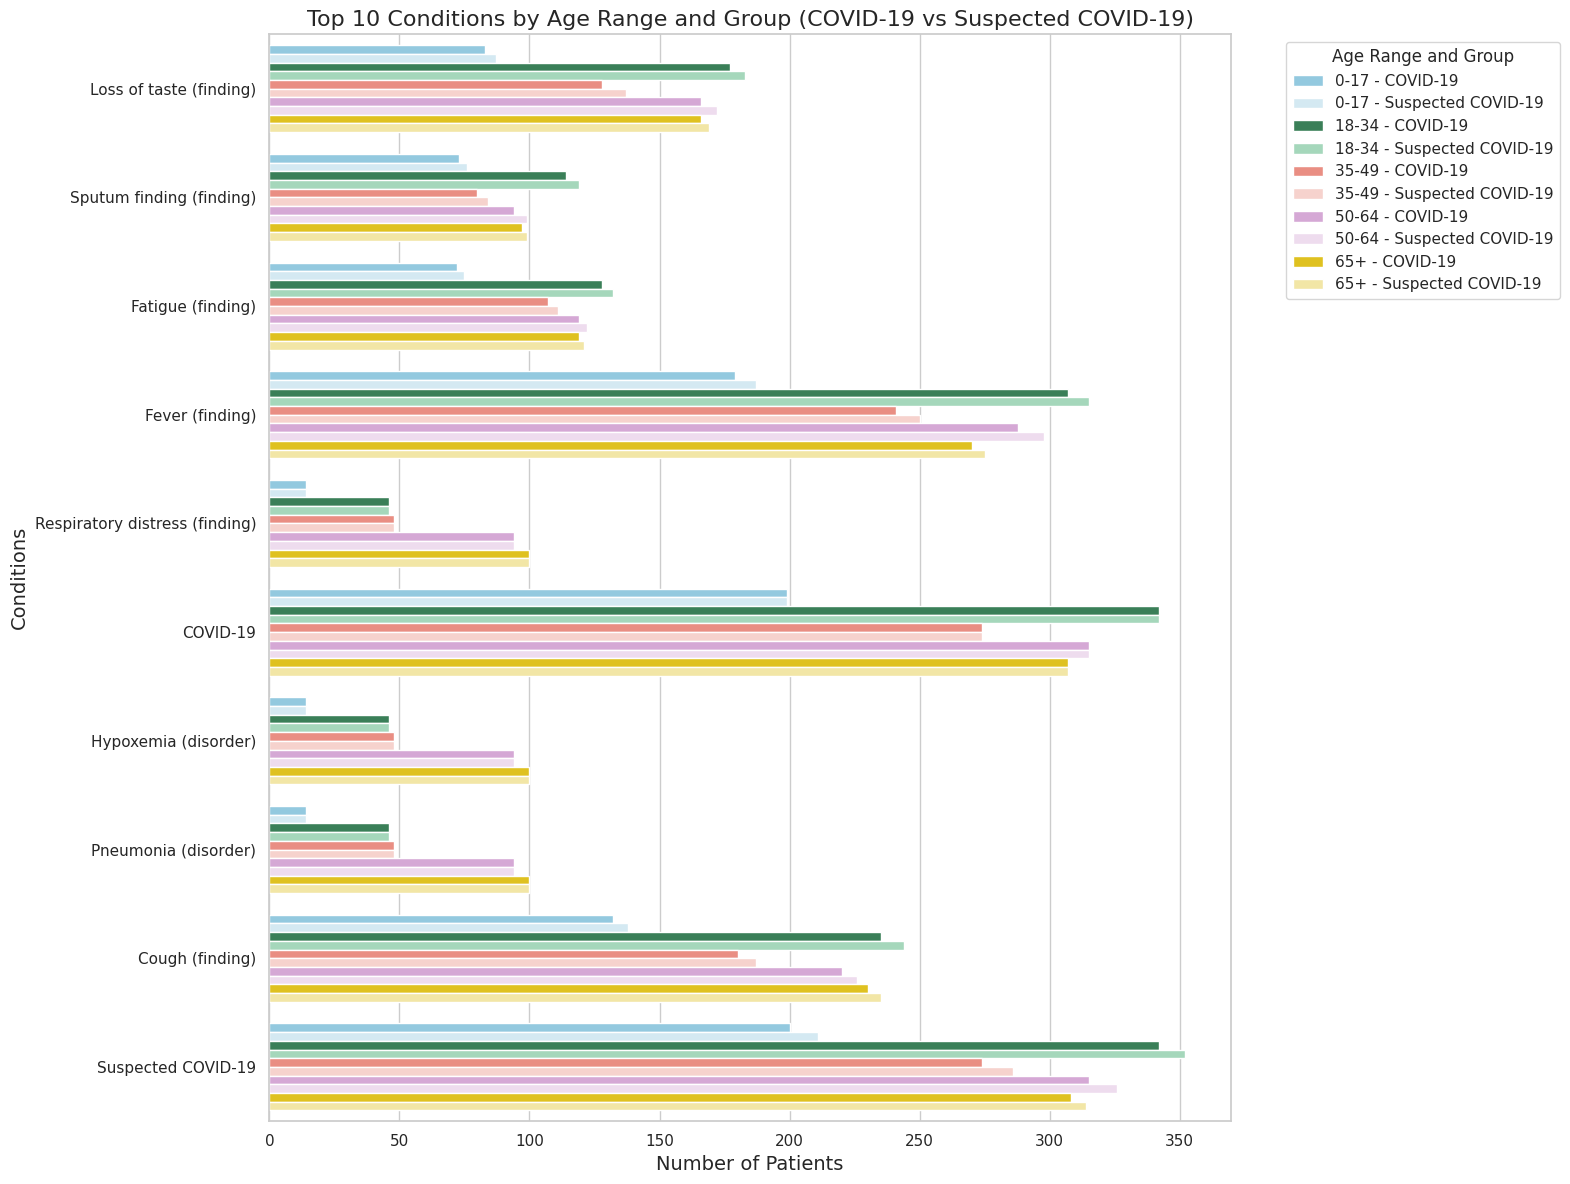

In [0]:
# Define a function to lighten colors
def lighten_color(color, amount=0.5):
    """Lightens the given color by multiplying (1-luminosity) by the given amount."""
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

# Get conditions and demographic
conditions_df = medical_records_df \
    .select(col("demographics.name"), explode(col("conditions")).alias("condition")) \
    .select(
        col("name"),
        col("condition.code").alias("condition_code"),
        col("condition.description").alias("condition_desc")
    )

# Group conditions per patient 
patient_conditions_df = conditions_df.groupBy("name") \
    .agg(collect_list("condition_desc").alias("co_morbidities"))

# Get outcome data with age included
outcomes_df = medical_records_df \
    .select(
        col("demographics.name"),
        col("demographics.age"),  # Include age
        col("laboratory.covid19.result").alias("covid_result"),
        when(col("vitals.current.oxygen_saturation.value") < 90, 1).otherwise(0).alias("icu_admission"),
        when(col("vitals.current.respiratory_rate.value") > 30, 1).otherwise(0).alias("severe_outcome")
    )

# Join patient conditions with outcomes 
combined_df = patient_conditions_df.join(
    outcomes_df, on="name", how="inner"
)

# Define age ranges
combined_df = combined_df.withColumn(
    "age_range",
    when(col("age") < 18, "0-17")
    .when((col("age") >= 18) & (col("age") < 35), "18-34")
    .when((col("age") >= 35) & (col("age") < 50), "35-49")
    .when((col("age") >= 50) & (col("age") < 65), "50-64")
    .otherwise("65+")
)

# Filter patients into two groups: COVID-19 and Suspected COVID-19
covid_df = combined_df.filter(array_contains(col("co_morbidities"), "COVID-19"))
suspected_df = combined_df.filter(array_contains(col("co_morbidities"), "Suspected COVID-19"))

# Flatten co-morbidities, group by condition and age range, and count for each group
covid_conditions_df = covid_df.select(
    explode(col("co_morbidities")).alias("condition"), col("age_range")
).groupBy("condition", "age_range").agg(count("*").alias("count"))

suspected_conditions_df = suspected_df.select(
    explode(col("co_morbidities")).alias("condition"), col("age_range")
).groupBy("condition", "age_range").agg(count("*").alias("count"))

# Convert to Pandas DataFrame for plotting
covid_conditions_pd = covid_conditions_df.toPandas()
suspected_conditions_pd = suspected_conditions_df.toPandas()

# Add group labels
covid_conditions_pd['group'] = 'COVID-19'
suspected_conditions_pd['group'] = 'Suspected COVID-19'

# Combine both dataframes
combined_conditions = pd.concat([covid_conditions_pd, suspected_conditions_pd])

# Prepare data for plotting (Top 10 conditions)
top_conditions = combined_conditions.groupby("condition")['count'].sum().nlargest(10).index
filtered_data = combined_conditions[combined_conditions['condition'].isin(top_conditions)]

# Create 'combined' column
filtered_data['combined'] = filtered_data['age_range'] + ' - ' + filtered_data['group']

# Define the order of combined categories
combined_order = []
age_range_order = ["0-17", "18-34", "35-49", "50-64", "65+"]
group_order = ["COVID-19", "Suspected COVID-19"]

for age in age_range_order:
    for group in group_order:
        combined_order.append(f"{age} - {group}")

# Define base colors for each age range
age_colors = {
    "0-17": "skyblue",
    "18-34": "seagreen",
    "35-49": "salmon",
    "50-64": "plum",
    "65+": "gold"
}

# Create shade_palette
shade_palette = {}
for age in age_range_order:
    base_color = age_colors[age]
    covid_color = base_color  # Darker shade
    suspected_color = lighten_color(base_color, amount=0.4)  # Lighter shade
    shade_palette[f"{age} - COVID-19"] = covid_color
    shade_palette[f"{age} - Suspected COVID-19"] = suspected_color

# Convert shade_palette to list in the order of combined_order
palette_list = [shade_palette[comb] for comb in combined_order]

# Plot using seaborn barplot
plt.figure(figsize=(16, 12))
sns.set(style="whitegrid")

sns.barplot(
    data=filtered_data,
    y="condition",
    x="count",
    hue="combined",
    hue_order=combined_order,
    palette=palette_list,
    ci=None
)

# Formatting the plot
plt.title("Top 10 Conditions by Age Range and Group (COVID-19 vs Suspected COVID-19)", fontsize=16)
plt.xlabel("Number of Patients", fontsize=14)
plt.ylabel("Conditions", fontsize=14)

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Age Range and Group", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Medication patterns analysis

"Rank medications by frequency of prescription."

In [0]:
# rank medications by frequency of prescription

all_medications = parsed_notes_df.select("medications.code", "medications.description")

# need to expode columns while maintaining relationships between the code + description arrays

med_code_desc = df.withColumn("zipped", expr("arrays_zip(medications.code, medications.description)"))
exploded_med_code_desc = med_code_desc.select(explode(col("zipped")).alias("exploded"))
all_medications = exploded_med_code_desc.select(
  col("exploded.code").alias("code"),
  col("exploded.description").alias("description")
)

all_medications_grouped = all_medications.groupBy("description").agg(count("*").alias("num_prescriptions")).orderBy(col("num_prescriptions").desc())
all_medications_grouped.show(5)

+--------------------+-----------------+
|         description|num_prescriptions|
+--------------------+-----------------+
|Acetaminophen 500...|              302|
|0.4 ML Enoxaparin...|              291|
|1 ML Epoetin Alfa...|              214|
|1 ML Enoxaparin s...|              174|
|NDA020503 200 ACT...|              165|
+--------------------+-----------------+
only showing top 5 rows



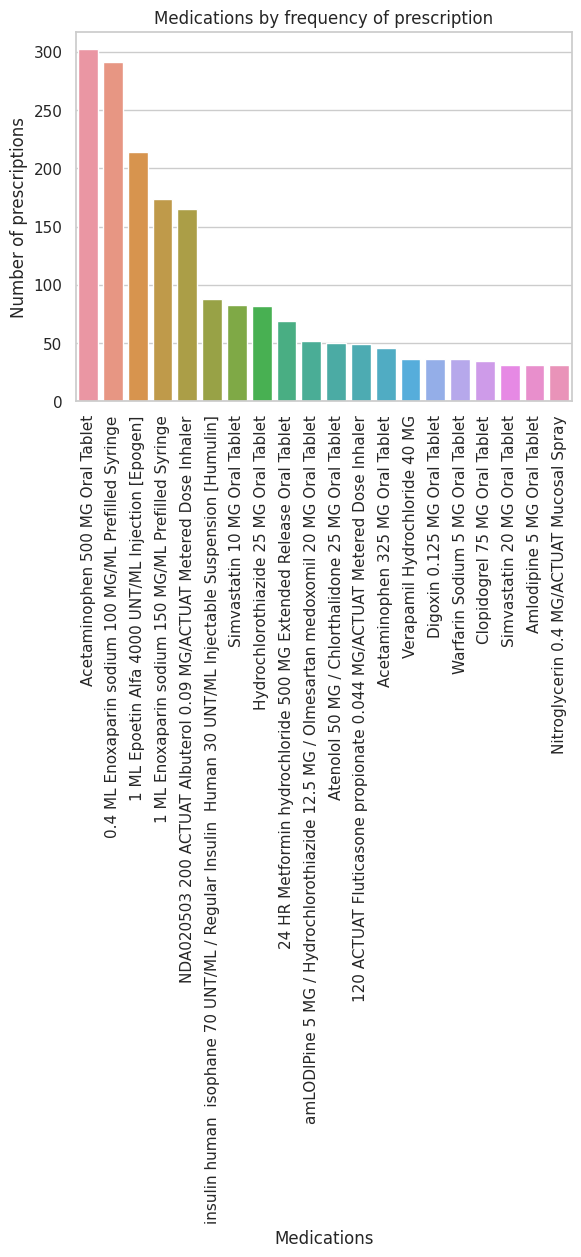

In [0]:
# making bar chart of top 20 prescriptions

sns.barplot(x="description", y="num_prescriptions", data=all_medications_grouped.limit(20).toPandas())

plt.xlabel("Medications")
plt.ylabel("Number of prescriptions")
plt.title("Medications by frequency of prescription")
plt.xticks(rotation=90)

plt.show()

"Analyze medication patterns across different demographic groups (e.g., top 3 per age group)"

In [0]:
# analyze medication patterns across different demographic groups (e.g., top 3 per age group)

# create bins by age 

medication_by_demographic = parsed_notes_df.select("demographics", "medications.code")
medication_by_demographic = medication_by_demographic.withColumn(
    "age range",
    when(col("demographics.age") <= 20, "0-20")
    .when((col("demographics.age") > 20) & (col("demographics.age") <= 40), "21-40")
    .when((col("demographics.age") > 40) & (col("demographics.age") <= 60), "41-60")
    .otherwise("61+")
)

# filter out people who did not receive medication

medication_by_demographic = medication_by_demographic.filter(col("code").isNotNull() & (size(col("code")) > 0))

# explode medications so they can be counted individually

exploded_medication = medication_by_demographic.withColumn("medication code", F.explode(F.col("code")))

# organize table to show top 3 most diagnosed medications for each age range

medication_by_demographic = exploded_medication.groupBy("age range", "medication code").agg(count("*").alias("medication count"))

window_spec = Window.partitionBy("age range").orderBy(col("medication count").desc())

ranked_medication_by_age = medication_by_demographic.withColumn("row_num", F.row_number().over(window_spec))

top_3_medication_by_age = ranked_medication_by_age.filter(F.col("row_num") <= 3).drop("row_num")

top_3_medication_by_age.show()

+---------+---------------+----------------+
|age range|medication code|medication count|
+---------+---------------+----------------+
|     0-20|        2123111|              23|
|     0-20|         854235|              21|
|     0-20|         198440|              21|
|    21-40|         198440|              56|
|    21-40|         854235|              54|
|    21-40|         854252|              34|
|    41-60|         854235|              96|
|    41-60|         198440|              96|
|    41-60|        2123111|              49|
|      61+|         205923|             214|
|      61+|         198440|             129|
|      61+|         854235|             120|
+---------+---------------+----------------+



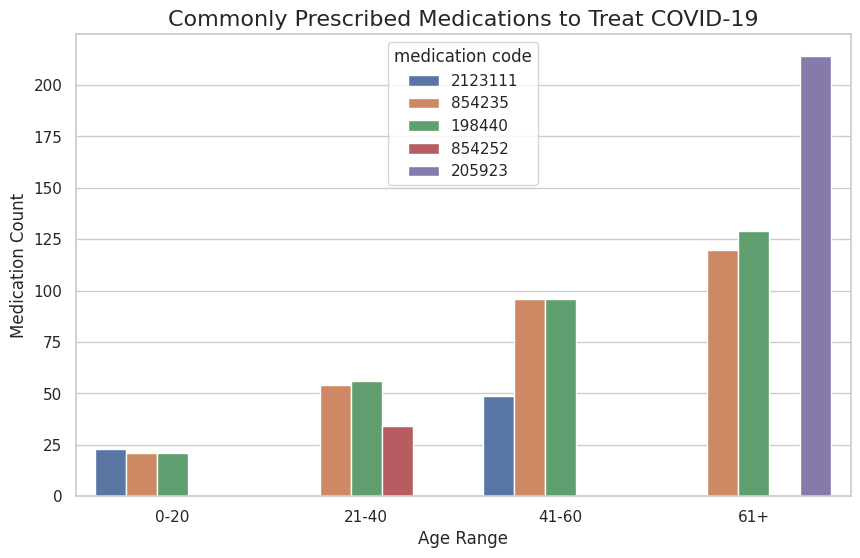

In [0]:
# making bar plot of medication count per age range

top_3_medication_by_age_pd = top_3_medication_by_age.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="age range", y="medication count", hue="medication code", data = top_3_medication_by_age_pd)

plt.title("Commonly Prescribed Medications to Treat COVID-19", fontsize=16)
plt.xlabel("Age Range", fontsize=12)
plt.ylabel("Medication Count", fontsize=12)

plt.show()

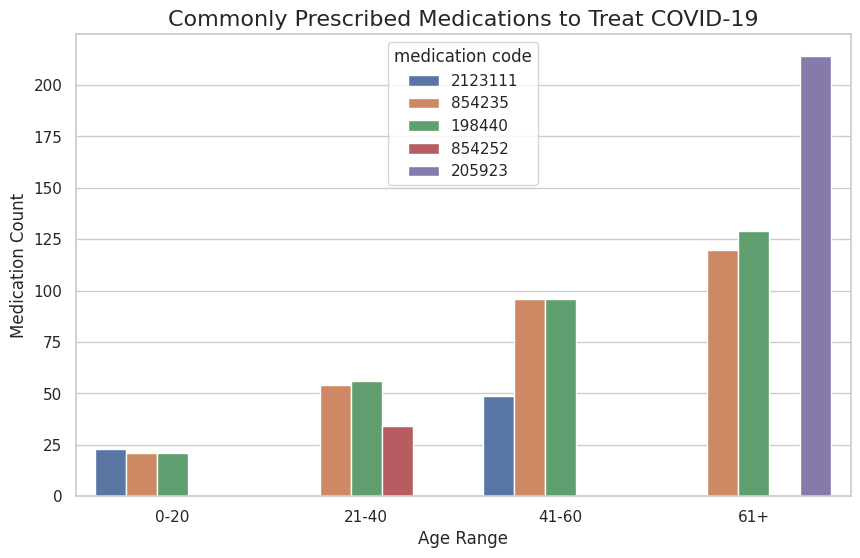

In [0]:
# making bar plot of medication count per age range

top_3_medication_by_age_pd = top_3_medication_by_age.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="age range", y="medication count", hue="medication code", data = top_3_medication_by_age_pd)

plt.title("Commonly Prescribed Medications to Treat COVID-19", fontsize=16)
plt.xlabel("Age Range", fontsize=12)
plt.ylabel("Medication Count", fontsize=12)

plt.show()


## Original analysis #3: COVID-19 cases by location + most common symptoms

<b> Analysis question: </b> What cities have the highest numbers of diagnosed COVID cases and how do symptoms vary for cities with high numbers of COVID cases?

This analysis can provide insight to possible patterns of symptoms within and between COVID hotspots and identify how COVID variants, environment, or other locational factors can affect how symptoms present.

In [0]:
cities_and_cases = parsed_notes_df.select("demographics", "conditions")

# group number of cases by city and show top 10 cities with the highest COVID diagnoses

cases_by_city = cities_and_cases.groupBy("demographics.address.city").agg(count("*").alias("number of diagnoses")).orderBy(col("number of diagnoses").desc())
cases_by_city.show(10)

+-----------+-------------------+
|       city|number of diagnoses|
+-----------+-------------------+
|     Boston|                184|
|  Worcester|                 60|
| Fall River|                 47|
|     Quincy|                 43|
|  Cambridge|                 37|
|     Lowell|                 36|
|Springfield|                 36|
|       Lynn|                 29|
| Barnstable|                 26|
|New Bedford|                 26|
+-----------+-------------------+
only showing top 10 rows



In [0]:
# filter data to top 3 locations

top_3_cities_and_cases = cities_and_cases.filter(F.col("demographics.address.city").isin("Boston", "Worcester", "Fall River"))

# filter out people who did not have symptoms

symptoms_by_demographic = top_3_cities_and_cases.filter(col("conditions.description").isNotNull() & (size(col("conditions.description")) > 0))

# explode symptoms so they can be counted individually

symptoms_by_demographic = symptoms_by_demographic.withColumn("symptom descriptions", F.explode(F.col("conditions.description")))

# organize table to show top 3 most diagnosed medications for each age range

symptoms_by_demographic = symptoms_by_demographic.groupBy("demographics.address.city", "symptom descriptions").agg(count("*").alias("cases")).orderBy(col("cases").desc())

symptoms_by_demographic.show(5)

+------+--------------------+-----+
|  city|symptom descriptions|cases|
+------+--------------------+-----+
|Boston|  Suspected COVID-19|  144|
|Boston|            COVID-19|  142|
|Boston|     Fever (finding)|  133|
|Boston|     Cough (finding)|  101|
|Boston|Loss of taste (fi...|   73|
+------+--------------------+-----+
only showing top 5 rows



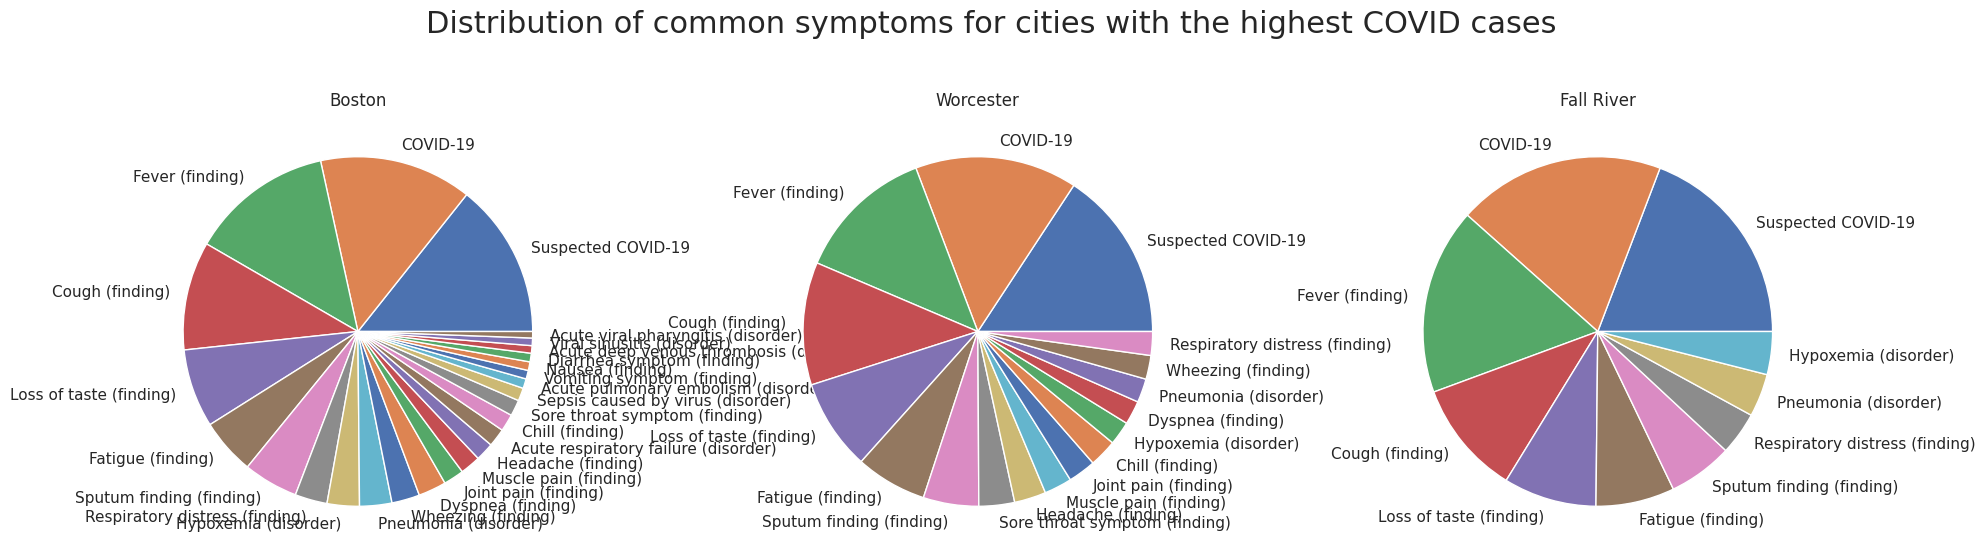

In [0]:
# making pie chart of symptoms from top 3 cities

# only plot symptoms with cases > 5 for visibility

common_symptoms = symptoms_by_demographic.filter(col("cases") > 5)

boston_data = common_symptoms.filter(col("city") == "Boston").toPandas()
worcester_data = common_symptoms.filter(col("city") == "Worcester").toPandas()
fr_data = common_symptoms.filter(col("city") == "Fall River").toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.subplots_adjust(top=0.3)

fig.suptitle("Distribution of common symptoms for cities with the highest COVID cases", fontsize=22) 

axes[0].pie(boston_data['cases'].astype(int), labels = boston_data['symptom descriptions'])
axes[0].set_title("Boston")

axes[1].pie(worcester_data['cases'].astype(int), labels = worcester_data['symptom descriptions']) 
axes[1].set_title("Worcester")

axes[2].pie(fr_data['cases'].astype(int), labels = fr_data['symptom descriptions']) 
axes[2].set_title("Fall River")

plt.tight_layout()
plt.show()